<a href="https://colab.research.google.com/github/prog815/progOrder/blob/main/%D0%B4%D0%BE%D0%B1%D0%B0%D0%B2%D0%BB%D1%8F%D0%B5%D0%BC_%D0%B4%D0%B0%D1%82%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка библиотек

In [1]:
! pip install finam-export
! pip install git+https://github.com/prog815/progGA
! pip install git+https://github.com/prog815/progOrder

  Cloning https://github.com/prog815/progGA to /tmp/pip-req-build-i9_e34zh
  Running command git clone -q https://github.com/prog815/progGA /tmp/pip-req-build-i9_e34zh
  Created wheel for progGA: filename=progGA-0.0.7-cp36-none-any.whl size=3732 sha256=b7cff0af61d03d102a2d2e4844ffe4cded1ffc08e2497aef334856b0f74407ae
  Stored in directory: /tmp/pip-ephem-wheel-cache-018x43rb/wheels/9c/7a/cc/d1ffa9ccaa42befda21d63d0e01c942a0add5854c37e0bd2ff
Successfully built progGA
  Cloning https://github.com/prog815/progOrder to /tmp/pip-req-build-rjj85xyx
  Running command git clone -q https://github.com/prog815/progOrder /tmp/pip-req-build-rjj85xyx
  Created wheel for progOrder: filename=progOrder-0.0.5-cp36-none-any.whl size=2485 sha256=18dda0c25a351c5bf5bc697c70644f91f554dc57c2e6336344bb5a4d1f040356
  Stored in directory: /tmp/pip-ephem-wheel-cache-mht7ls43/wheels/55/73/64/80cff258e67e5c7a4b92084f656d1e4f2f48a7543da44468f2
Successfully built progOrder


In [2]:
from finam import Exporter, Market
import datetime
import pandas as pd
import numpy as np
import seaborn as snb
import matplotlib.pyplot as plt
from progGA import ListGenetic
from progOrder import getBuySellForData, kach, bs2y, y2bs
import pickle
import os
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# import tensorflow as tf
# import tensorflow.keras as keras
# import tensorflow.keras.layers as layers

from sklearn.metrics import confusion_matrix,f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier

import bz2

# Загрузка данных

In [3]:
exporter = Exporter()
sber = exporter.lookup(code='SBER', market=Market.SHARES)
data = exporter.download(sber.index[0],market=Market.SHARES,start_date=datetime.date(2008, 1, 1))
data.drop('<TIME>',axis=1,inplace=True)
data.set_index('<DATE>',inplace=True)
data.set_index(pd.to_datetime(data.index,format='%Y%m%d'),inplace=True)
data

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
<DATE>,,,,,
2008-01-09,101.99,103.70,100.72,101.85,32124562
2008-01-10,102.07,103.81,101.53,103.53,39745084
2008-01-11,103.60,105.45,102.86,104.70,32814608
2008-01-14,104.28,105.30,104.20,105.00,20709850
2008-01-15,105.20,106.60,104.80,105.71,51441473
...,...,...,...,...,...
2020-12-30,272.50,274.24,270.12,271.65,31509500
2021-01-04,274.67,276.60,270.61,272.00,48799460
2021-01-05,272.67,275.70,270.28,275.20,45554100


In [4]:
ohlcv = data.values[:,:5]
d_ohlcv = np.array(ohlcv)
for n in range(1,len(ohlcv)):
    b = ohlcv[n-1,3]
    d_ohlcv[n,:] = (ohlcv[n,:] - b) / b
d_ohlcv[0,:] = np.nan

data['dOpen'] = d_ohlcv[:,0]
data['dHigh'] = d_ohlcv[:,1]
data['dLow'] = d_ohlcv[:,2]
data['dClose'] = d_ohlcv[:,3]

data

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,dOpen,dHigh,dLow,dClose
<DATE>,,,,,,,,,
2008-01-09,101.99,103.70,100.72,101.85,32124562,NaN,NaN,NaN,NaN
2008-01-10,102.07,103.81,101.53,103.53,39745084,0.002160,0.019244,-0.003142,0.016495
2008-01-11,103.60,105.45,102.86,104.70,32814608,0.000676,0.018545,-0.006472,0.011301
2008-01-14,104.28,105.30,104.20,105.00,20709850,-0.004011,0.005731,-0.004776,0.002865
2008-01-15,105.20,106.60,104.80,105.71,51441473,0.001905,0.015238,-0.001905,0.006762
...,...,...,...,...,...,...,...,...,...
2020-12-30,272.50,274.24,270.12,271.65,31509500,0.001838,0.008235,-0.006912,-0.001287
2021-01-04,274.67,276.60,270.61,272.00,48799460,0.011117,0.018222,-0.003828,0.001288
2021-01-05,272.67,275.70,270.28,275.20,45554100,0.002463,0.013603,-0.006324,0.011765


# Поиск гиперпараметров

## Целевая функция

In [5]:
# %%time

orderLifeLen = 50                           # срок жизни ордера

allLen = data.shape[0]                      # размер всей выборки
allIdx = np.arange(allLen,dtype=np.int16)
testPart = 0.1                              # доля тестовой
testLen = int(np.round(allLen*testPart))    # длина тестовой выборки
trainLen = allLen - orderLifeLen - testLen  # длина трейновой выборки (обучающая + валидационная)
valPart = 0.2                               # доля валидации для генетики
valLen = int(np.round(trainLen*valPart))    # длина валидационной выборки

# --------------------------------------------------

def get_X(lookback):
    X = np.hstack([data[['dOpen','dHigh','dLow','dClose','<VOL>']].shift(n) for n in range(lookback)])
    X = np.hstack((X,np.vstack((data.index.month,data.index.day,data.index.dayofweek)).T))
    return X

# --------------------------------------------------

class Element:
    
    lookback = None
    model = None
    dTP = None
    dSL = None
    
    def __init__(self,model,lookback,dTP,dSL):
        self.lookback = lookback
        self.model = model
        self.dTP = dTP
        self.dSL = dSL

    def predict(self):
        X = get_X(self.lookback)
        idx = ~np.any(np.isnan(X),axis=1)
        y_ = X[:,0] * np.nan
        b_, s_ = np.copy(y_), np.copy(y_)
        y_[idx] = self.model.predict(X[idx])
        b_[idx],s_[idx] = y2bs(y_[idx])
        return b_,s_
        
# --------------------------------------------------

class Ansambl:
    elements = None
    count = None
    last = None

    def __init__(self,cnt):
        self.count = cnt
        self.elements = [ None ] * self.count
        self.last = -1

    def append(self,model,lookback,dTP,dSL):
        element = Element(model=model,lookback=lookback,dTP=dTP,dSL=dSL)
        self.last += 1
        self.elements[self.last % self.count] = element

    def predict(self):
        b,s,dTP,dSL = [],[],[],[]
        for element in self.elements:
            try:
                b_,s_ = element.predict()
                dTP_, dSL_ = element.dTP, element.dSL
                b.append(b_)
                s.append(s_)
                dTP.append(dTP_)
                dSL.append(dSL_)
            except Exception:
                pass
        b_ = np.mean(b,axis=0)
        s_ = np.mean(s,axis=0)
        dTP_,dTP_std = np.mean(dTP),np.std(dTP)
        dSL_,dSL_std = np.mean(dSL),np.std(dSL)

        b,s = getBuySellForData(ohlcv[:,:-1],orderLifeLen=orderLifeLen,dSL=dSL_,dTP=dTP_)
        bs_y = np.vstack((b,s)).T
        bs_y_ = np.vstack((b_,s_)).T
        idx = allIdx[~np.any(np.isnan(bs_y + bs_y_),axis=1)]
        
        idxTrain = idx[idx<trainLen]
        kachTrain = kach(np.round(bs_y_[idxTrain]),bs_y[idxTrain],dTP_,dSL_)

        idxTest = idx[(idx>=trainLen) & (idx<(trainLen+testLen))]
        kachTest = kach(np.round(bs_y_[idxTest]),bs_y[idxTest],dTP_,dSL_)
        
        return b_,s_,dTP_,dSL_,dTP_std,dSL_std,kachTrain,kachTest


ansmbl = Ansambl(cnt=100)

# --------------------------------------------------

def getQualityMethod(lookback,     # окно задержки
                     max_depth,    # максимальная глубина дерева
                     n_estimators, # кол-во эстиматоров
                     dTP,          # тейк-профит
                     dSL):         # стоплос
                     
    # подготовка сигналов
    b,s = getBuySellForData(ohlcv[:,:-1],orderLifeLen=orderLifeLen,dSL=dSL,dTP=dTP)

    # подготовка входов
    X = get_X(lookback)
    y = b*2+s

    # берем только трейновую выборку
    X = X[:trainLen]
    y = y[:trainLen]

    # отбор реальных значений
    idx = ~np.any(np.isnan(X),axis=1) 
    X = X[idx]
    y = y[idx]
    
    # разделение выборок
    try:
        X_learn, X_valid, y_learn, y_valid = train_test_split(X,y,shuffle=True,test_size=valPart,stratify=y)
    except Exception:
        return -dSL
    
    # создание модели

    model = RandomForestClassifier(max_depth=max_depth,class_weight='balanced',n_estimators=n_estimators)

    # обучение модели

    model.fit(X_learn, y_learn)

    # возвращаем точности на отборе генетики
    
    # print(model.evaluate(X_valid,y_valid))
    pred_valid = model.predict(X_valid)
    # print(np.mean(pred_valid,axis=0),np.std(pred_valid,axis=0))
    # print('pred_valid',np.unique(pred_valid,return_counts=True))
    # print('y_valid',np.unique(y_valid,return_counts=True))

    # print(confusion_matrix(y_valid,pred_valid))
    # print(classification_report(y_valid,pred_valid))
    
    # raise Exception(1)
    num2bs = lambda num : np.array([[b,s] for b,s in zip(*y2bs(num))])
    res = kach(num2bs(pred_valid),num2bs(y_valid),dTP,dSL)

    if res == 0.0:  # не нужны тупые бездействующие модели
        res = -dSL*2.0

    # element = Element(model=model,lookback=lookback,dTP=dTP,dSL=dSL)
    if res > 0:
        ansmbl.append(model=model,lookback=lookback,dTP=dTP,dSL=dSL)

    return res

res = getQualityMethod(30,7,200,0.004,0.01)
print(res)

-0.0018056042031523644


## Создание модели

### Создание

In [6]:
modelGA = ListGenetic(pop_size = 200,
                      lookback = range(10,300),
                      max_depth = range(2,100),
                      n_estimators = range(10,500),
                      dTP = np.round(np.arange(0.0001,0.01,0.0001),4),
                      dSL = np.round(np.arange(0.0001,0.01,0.0001),4),
                      quality_method=getQualityMethod)

### или загрузка с диска

In [7]:
fn = '/content/drive/My Drive/prog/model_dd_06.01.2021.pkl'
fn_ans = '/content/drive/My Drive/prog/model_dd_ans_06.01.2021.pkl'

if os.path.exists(fn):
    with open(fn,'rb') as fp:
        modelGA = pickle.load(fp)

if os.path.exists(fn_ans):
    with bz2.BZ2File(fn_ans, 'rb') as fp:
        ansmbl = pickle.load(fp)

## Бесконечный цикл обучения

In [14]:
while True:
    modelGA.fit(50,echo_time=60)
    with open(fn,'wb') as fp:
        pickle.dump(modelGA,fp)

    with bz2.BZ2File(fn_ans, 'wb') as fp:
        pickle.dump(ansmbl,fp)

2217 {'quality': -8.801498127340822e-06, 'lookback': 218, 'max_depth': 20, 'n_estimators': 177, 'dTP': 0.0028, 'dSL': 0.0075}
2220 {'quality': -9.683544303797468e-05, 'lookback': 119, 'max_depth': 21, 'n_estimators': 490, 'dTP': 0.0037, 'dSL': 0.0078}
2225 {'quality': -1.7790262172284642e-06, 'lookback': 215, 'max_depth': 41, 'n_estimators': 276, 'dTP': 0.0027, 'dSL': 0.0073}
2229 {'quality': 2.4299065420560745e-06, 'lookback': 213, 'max_depth': 40, 'n_estimators': 465, 'dTP': 0.0026, 'dSL': 0.0072}
2233 {'quality': -5.0373831775700935e-05, 'lookback': 210, 'max_depth': 91, 'n_estimators': 162, 'dTP': 0.0077, 'dSL': 0.0077}
2237 {'quality': 5.660377358490566e-06, 'lookback': 236, 'max_depth': 47, 'n_estimators': 461, 'dTP': 0.003, 'dSL': 0.0076}
2243 {'quality': -0.0144, 'lookback': 212, 'max_depth': 23, 'n_estimators': 257, 'dTP': 0.0027, 'dSL': 0.0072}
2247 {'quality': -9.539473684210526e-05, 'lookback': 226, 'max_depth': 90, 'n_estimators': 161, 'dTP': 0.0075, 'dSL': 0.0077}
2252 {'

KeyboardInterrupt: ignored

## Графики

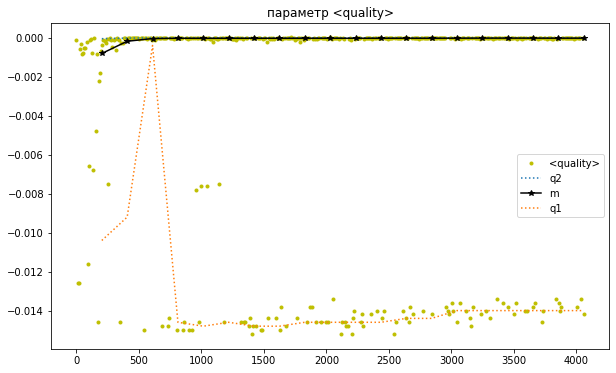

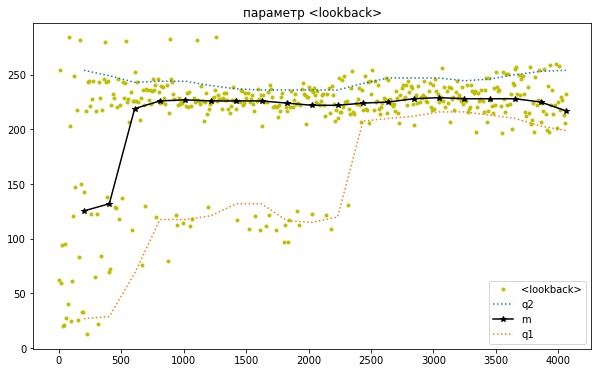

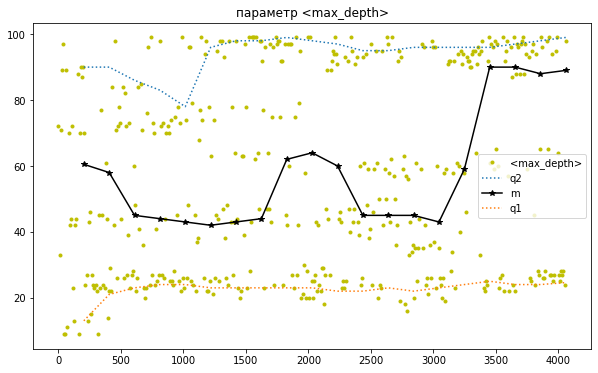

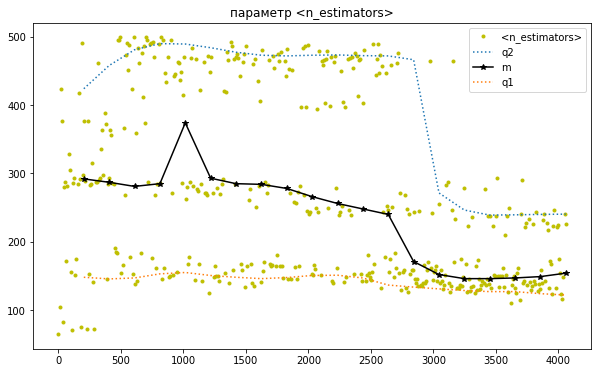

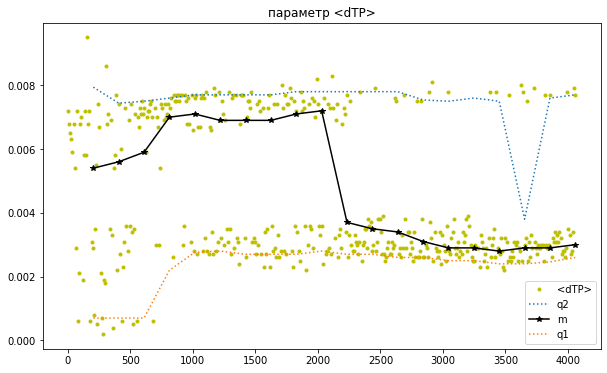

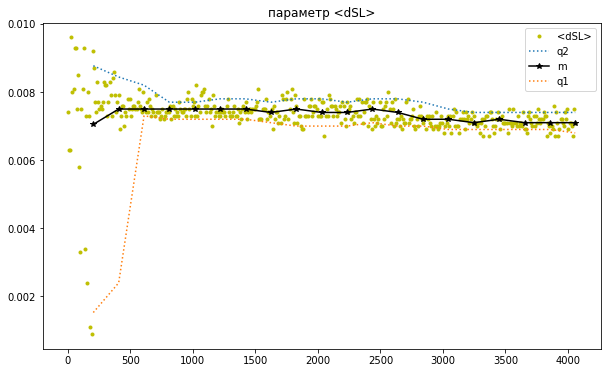

In [15]:
modelGA.plot_hist_new(('quality','lookback','max_depth','n_estimators','dTP','dSL'))

In [16]:
for n,h in enumerate(modelGA._hist):
    if h['new']['quality'] > 0:
        print(n,h['new'])


32 {'quality': 1.1858407079646019e-05, 'lookback': 61, 'max_depth': 27, 'n_estimators': 338, 'dTP': 0.0073, 'dSL': 0.0075}
42 {'quality': 4.347826086956522e-06, 'lookback': 241, 'max_depth': 79, 'n_estimators': 380, 'dTP': 0.0061, 'dSL': 0.0076}
211 {'quality': 4.3816254416961126e-05, 'lookback': 57, 'max_depth': 74, 'n_estimators': 170, 'dTP': 0.0072, 'dSL': 0.0073}
213 {'quality': 3.095684803001876e-06, 'lookback': 221, 'max_depth': 44, 'n_estimators': 279, 'dTP': 0.0033, 'dSL': 0.0074}
241 {'quality': 6.603773584905661e-06, 'lookback': 235, 'max_depth': 23, 'n_estimators': 275, 'dTP': 0.0074, 'dSL': 0.0076}
258 {'quality': 3.0303030303030305e-06, 'lookback': 244, 'max_depth': 45, 'n_estimators': 495, 'dTP': 0.0032, 'dSL': 0.0076}
270 {'quality': 6.591337099811676e-07, 'lookback': 228, 'max_depth': 27, 'n_estimators': 315, 'dTP': 0.0007, 'dSL': 0.0075}
283 {'quality': 9.074410163339376e-07, 'lookback': 128, 'max_depth': 72, 'n_estimators': 492, 'dTP': 0.0029, 'dSL': 0.0077}
299 {'qua

In [17]:
ansmbl.last

542

## Параметры лучшей

In [18]:
best_par = modelGA.getBestParams()
best_par

{'dSL': 0.0071,
 'dTP': 0.0035,
 'lookback': 218,
 'max_depth': 67,
 'n_estimators': 179}

# Результаты ансамбля

In [19]:
# %%time
b_,s_,dTP_,dSL_,dTP_std,dSL_std,kachTrain,kachTest=ansmbl.predict()
print('dTP_',dTP_,'dTP_std',dTP_std)
print('dSL_',dSL_,'dSL_std',dSL_std)
print('kachTrain',kachTrain,'%/year',((kachTrain+1)**252-1)*100)
print('kachTest',kachTest,'%/year',((kachTest+1)**252-1)*100)

dTP_ 0.00395 dTP_std 0.002051072889977341
dSL_ 0.007141 dSL_std 0.0001954968030429142
kachTrain 0.0009125219214639727 %/year 25.84120750384851
kachTest 0.0 %/year 0.0


In [20]:
df_=pd.DataFrame(index=data.index)
df_['BUY'] = b_
df_['BUY_open'] = data['<CLOSE>']
df_['BUY_tp'] = np.round(data['<CLOSE>']*(1+dTP_),2)
df_['BUY_sl'] = np.round(data['<CLOSE>']*(1-dSL_),2)
df_['SELL'] = s_
df_['SELL_open'] = data['<CLOSE>']
df_['SELL_tp'] = np.round(data['<CLOSE>']*(1-dTP_),2)
df_['SELL_sl'] = np.round(data['<CLOSE>']*(1+dSL_),2)
df_

,BUY,BUY_open,BUY_tp,BUY_sl,SELL,SELL_open,SELL_tp,SELL_sl
<DATE>,,,,,,,,
2008-01-09,NaN,101.85,102.25,101.12,NaN,101.85,101.45,102.58
2008-01-10,NaN,103.53,103.94,102.79,NaN,103.53,103.12,104.27
2008-01-11,NaN,104.70,105.11,103.95,NaN,104.70,104.29,105.45
2008-01-14,NaN,105.00,105.41,104.25,NaN,105.00,104.59,105.75
2008-01-15,NaN,105.71,106.13,104.96,NaN,105.71,105.29,106.46
...,...,...,...,...,...,...,...,...
2020-12-30,0.0,271.65,272.72,269.71,0.0,271.65,270.58,273.59
2021-01-04,0.0,272.00,273.07,270.06,0.0,272.00,270.93,273.94
2021-01-05,0.0,275.20,276.29,273.23,0.0,275.20,274.11,277.17
